In [1]:
import torch
from simple_vit import SimpleVisionTransformer
import torchvision.datasets as datasets
from torchvision.transforms import v2
from scipy.stats import entropy

In [15]:
import numpy as np

# I tried to prevent TensorFlow from taking all GPU RAM for hours to no avail, so I had to resort to using CPU for the grafted experiment.
# You should use GPU if you can overcome this issue.
device = torch.device("cpu")
# device = torch.device("cuda")

def gather_stats(ckpt_path, ds, device):
    hidden_dim = 384
    input_resolution = 224
    
    vit = SimpleVisionTransformer(
        image_size=input_resolution,
        patch_size=16,
        num_layers=12,
        num_heads=6,
        hidden_dim=hidden_dim,
        mlp_dim=hidden_dim * 4
    )

    ckpt = torch.load(ckpt_path, weights_only=True)
    try:
        vit.load_state_dict(ckpt['state_dict'])
    except:
        vit.load_state_dict({k[len('module.'):]: v for k, v in ckpt['state_dict'].items()})

    vit = vit.to(device)
    result = []

    for _, batch in enumerate(ds):
        images, target = batch
        images = images.to(device)
        target = target.to(device)
        images.requires_grad = True
        logits, _ = vit(images, 1.0, target, target)
        target_logits = logits[torch.arange(logits.shape[0]), target]
        total = sum(target_logits)
        total.backward()
        grad_sum_clipped = torch.clamp(images.grad.sum(dim=1), min=0.)
        grad_sum_clipped_normalized = grad_sum_clipped / grad_sum_clipped.sum(dim=(1, 2), keepdim=True)
        grad_sum_clipped_normalized = grad_sum_clipped_normalized.flatten(start_dim=1).cpu().numpy()
        result.append(entropy(grad_sum_clipped_normalized, axis=1))

    return np.concatenate(result, dtype=np.float32)

In [4]:
import tensorflow as tf
# This is one of the recommended way to prevent TF from using GPU, but didn't work.
tf.config.set_visible_devices([], "GPU")

# Just the necessary parts of Big Vision
def _resize_factor(image, factor, method="area", antialias=True):
  """Resizes the image by a (float) `factor`, keeping the aspect ratio fixed."""
  h, w = tf.shape(image)[0], tf.shape(image)[1]

  h = tf.cast(tf.round(tf.cast(h, tf.float32) * factor), tf.int32)
  w = tf.cast(tf.round(tf.cast(w, tf.float32) * factor), tf.int32)

  dtype = image.dtype
  tf_dtype = tf.type_spec_from_value(image).dtype
  image = tf.image.resize(image, (h, w), method=method, antialias=antialias)
  return tf.cast(tf.clip_by_value(image, tf_dtype.min, tf_dtype.max), dtype)

def get_resize_small(smaller_size, method="area", antialias=False):
  """Resizes the smaller side to `smaller_size` keeping aspect ratio.

  Args:
    smaller_size: an integer, that represents a new size of the smaller side of
      an input image.
    method: the resize method. `area` is a meaningful, bwd-compat default.
    antialias: see tf.image.resize. Ideally set to True for all new configs.

  Returns:
    A function, that resizes an image and preserves its aspect ratio.

  Note:
    backwards-compat for "area"+antialias tested here:
    (internal link)
  """

  def _resize_small(image):  # pylint: disable=missing-docstring
    h, w = tf.shape(image)[0], tf.shape(image)[1]
    factor = (
        tf.cast(smaller_size, tf.float32) /
        tf.cast(tf.minimum(h, w), tf.float32))
    return _resize_factor(image, factor, method=method, antialias=antialias)
  return _resize_small

def get_central_crop(crop_size=None):
  """Makes central crop of a given size.

  Args:
    crop_size: either an integer H, where H is both the height and width of the
      central crop, or a list or tuple [H, W] of integers, where H and W are
      height and width of the central crop respectively. If `crop_size` is not
      specified, then the largest possible center crop will be taken.

  Returns:
    A function, that applies central crop.
  """
  def _crop(image):
    if crop_size:
      h, w = crop_size[0], crop_size[1]
    else:
      h = w = tf.minimum(tf.shape(image)[0], tf.shape(image)[1])
    dy = (tf.shape(image)[0] - h) // 2
    dx = (tf.shape(image)[1] - w) // 2
    return tf.image.crop_to_bounding_box(image, dy, dx, h, w)

  return _crop

def get_value_range(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False):
  """Transforms a [in_min,in_max] image to [vmin,vmax] range.

  Input ranges in_min/in_max can be equal-size lists to rescale the invidudal
  channels independently.

  Args:
    vmin: A scalar. Output max value.
    vmax: A scalar. Output min value.
    in_min: A scalar or a list of input min values to scale. If a list, the
      length should match to the number of channels in the image.
    in_max: A scalar or a list of input max values to scale. If a list, the
      length should match to the number of channels in the image.
    clip_values: Whether to clip the output values to the provided ranges.

  Returns:
    A function to rescale the values.
  """

  def _value_range(image):
    """Scales values in given range."""
    in_min_t = tf.constant(in_min, tf.float32)
    in_max_t = tf.constant(in_max, tf.float32)
    image = tf.cast(image, tf.float32)
    image = (image - in_min_t) / (in_max_t - in_min_t)
    image = vmin + image * (vmax - vmin)
    if clip_values:
      image = tf.clip_by_value(image, vmin, vmax)
    return image

  return _value_range

rs = get_resize_small(256)
cc = get_central_crop((224, 224))
vr = get_value_range(-1, 1)

def preprocess(row):
    image, target = row['image'], row['label']
    image = vr(cc(rs(image)))
    return image, target

2024-12-18 17:37:47.900664: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-18 17:37:47.928848: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-18 17:37:47.928871: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-18 17:37:47.929617: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-18 17:37:47.934589: I tensorflow/core/platform/cpu_feature_guar

In [5]:
import tensorflow_datasets as tfds

In [6]:
hidden_dim = 384
input_resolution = 224

vit = SimpleVisionTransformer(
    image_size=input_resolution,
    patch_size=16,
    num_layers=12,
    num_heads=6,
    hidden_dim=hidden_dim,
    mlp_dim=hidden_dim * 4
)

ckpt_path = "/data/imagenet/grafted-fixed/model_best.pth.tar"
ckpt = torch.load(ckpt_path, weights_only=True)
vit.load_state_dict(ckpt['state_dict'])

<All keys matched successfully>

In [7]:
vit = vit.to(device)

In [8]:
def correct(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
        
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k)
        return res

In [9]:
print(tf.config.list_logical_devices('GPU'))

[]


In [10]:
import dlpack

ds = tfds.load('imagenet2012', split='validation')
ds = ds.map(preprocess).batch(128).prefetch(1)
def shim(ds):
    for images, target in ds:
        images, target = torch.from_dlpack(dlpack.asdlpack(images)), torch.from_dlpack(dlpack.asdlpack(target))
        images = images.permute(0, 3, 1, 2)
        yield images, target

total = 0
torch.cuda.empty_cache()
for images, target in shim(ds):
    images = images.to(device)
    target = target.to(device)
    output, _ = vit(images, 1.0, target, target)
    corr, = correct(output, target)
    total += corr.item()

print(total / 50000)

0.7671


In [ ]:
USER = '** redacted **'

checkpoints = ["/data/imagenet-runs/logs/90ep-repo-attempt12/checkpoints/model_best.pth.tar",
               "/data/imagenet-runs/logs/90ep-true-reproduction/checkpoints/model_best.pth.tar",
               "/data/imagenet-runs/logs/linear-head-90ep/checkpoints/model_best.pth.tar",
               "/data/imagenet/grafted-fixed/model_best.pth.tar"]

filenames = [f"/home/{USER}/Downloads/90ep-repo-attempt12-entropy",
             f"/home/{USER}/Downloads/90ep-true-reproduction-entropy",
             f"/home/{USER}/Downloads/linear-head-90ep-entropy",
             f"/home/{USER}/Downloads/90ep-grafted-entropy"]

In [16]:
for ckpt_path, filename in zip(checkpoints, filenames):
    result = gather_stats(ckpt_path, shim(ds), device)
    np.save(filename + '-bv-pp', result)

In [17]:
result.shape

(50000,)

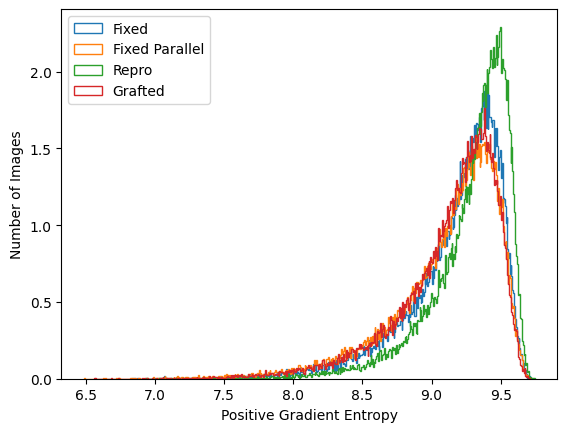

In [19]:
import matplotlib.pyplot as plt

filenames = [f"/home/{USER}/Downloads/90ep-repo-attempt12-entropy",
             f"/home/{USER}/Downloads/linear-head-90ep-entropy",
             f"/home/{USER}/Downloads/90ep-true-reproduction-entropy",
             f"/home/{USER}/Downloads/90ep-grafted-entropy"]
labels = ["Fixed", "Fixed Parallel", "Repro", "Grafted"]

for filename, label in zip(filenames, labels):
    result = np.load(filename + '-bv-pp.npy')
    plt.hist(result, 500, density=True, histtype='step', label=label)

plt.legend(loc="upper left")
plt.xlabel("Positive Gradient Entropy")
plt.ylabel("Number of Images")
plt.savefig(f"/home/{USER}/Downloads/90ep-pixel-grad-comparison-bv-pp-only.png")
plt.show()